In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import itertools

In [3]:
mat = loadmat('ex4data1.mat')
raw_X = mat['X']
raw_y = mat['y']
print(raw_X.shape, raw_y.shape)

(5000, 400) (5000, 1)


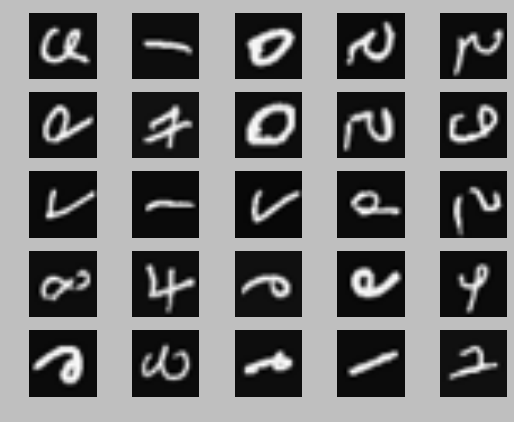

In [4]:
plot_indices = itertools.product(range(5), range(5))
images_indices = np.random.randint(0, 5000, size=25)

(f, ax) = plt.subplots(5, 5)
for (i, (j, k)) in zip(images_indices, plot_indices):
    image = raw_X[i, :].reshape(20, 20)
    ax[j, k].imshow(image, cmap='gray')
    ax[j, k].axis('off')
    
plt.show()

In [122]:
def to_one_hot_labels(labels, k):
    m = len(labels)
    y = np.zeros((m, k))
    # matlabl indices: 1 to 10, python indices: 0 to 9
    labels = labels - 1
    for i in range(m):
        y[i, labels[i, 0]] = 1
        
    return y

In [123]:
X = raw_X.copy()
y = to_one_hot_labels(raw_y.copy(), k=10)

In [124]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

g = sigmoid

def dsigmoid_dz(z):
    return np.multiply(g(z), 1 - g(z))

In [125]:
def J(x, y, l, thetas, debug=False):
    # forward
    a1 = x.T
    bias = np.ones((1, a1.shape[1]))
    a1 = np.vstack([bias, a1])
    
    z2 = thetas[0].dot(a1)
    a2 = g(z2)
    bias = np.ones((1, a2.shape[1]))
    a2 = np.vstack([bias, a2])
    
    z3 = thetas[1].dot(a2)
    a3 = g(z3)
    h_theta_x = a3.T
    
    #loss
    y1 = np.multiply(-y, np.log(h_theta_x)).sum()
    y0 = np.multiply(1 - y, np.log(1 - h_theta_x)).sum()
    m = h_theta_x.shape[0]
    cost = (1.0 / m) * (y1 - y0)
    
    regs = [(t[:, 1:] ** 2).sum() for t in thetas]
    reg = (l / (2.0 * m)) * sum(regs)
    
    loss = cost + reg
    
    if debug:
        return loss
    
    # Backpropagation
    d3 = h_theta_x - y
    
    d2 = d3.dot(thetas[1][:, 1:])
    g_prime = dsigmoid_dz(z2.T)
    d2 = np.multiply(d2, g_prime)
    
    D1 = d2.T.dot(a1.T) * (1.0 / m)
    D1[:, 1:] += ((l / m) * thetas[0][:, 1:])
    D2 = d3.T.dot(a2.T) * (1.0 / m)
    D2[:, 1:] += ((l / m) * thetas[1][:, 1:])
    
    DELTA = [D1, D2]
        
    return (loss, DELTA)

In [126]:
# test case from
# https://www.coursera.org/learn/machine-learning/discussions/weeks/5/threads/uPd5FJqnEeWWpRIGHRsuuw
# https://www.coursera.org/learn/machine-learning/discussions/all/threads/a8Kce_WxEeS16yIACyoj1Q

tt = np.arange(1, 19) / 10.0
t1 = tt[:6].reshape(3, 2).T
t2 = tt[6:].reshape(3, 4).T
tt = [t1, t2]
tx = np.cos(np.asarray([[1, 2], [3, 4], [5, 6]]))
ty = np.asarray([[4], [2], [3]])
ty = to_one_hot_labels(ty, 4)

print('Unregularized')
(loss, grads) = J(tx, ty, float(0), tt)
print('Loss', loss)
print(grads[0].T.reshape((-1, 1)))
print(grads[1].T.reshape((-1, 1)))

print('Regularized')
(loss, grads) = J(tx, ty, float(4), tt)
print('Loss', loss)
print(grads[0].T.reshape((-1, 1)))
print(grads[1].T.reshape((-1, 1)))

Unregularized
Loss 7.40696985607
[[ 0.76613837]
 [ 0.97989687]
 [-0.02753962]
 [-0.03584421]
 [-0.02492878]
 [-0.05386169]]
[[ 0.88341721]
 [ 0.56876234]
 [ 0.58466766]
 [ 0.59813924]
 [ 0.45931355]
 [ 0.34461818]
 [ 0.25631333]
 [ 0.31188506]
 [ 0.47833662]
 [ 0.36892041]
 [ 0.25977062]
 [ 0.32233089]]
Regularized
Loss 19.4736365227
[[ 0.76613837]
 [ 0.97989687]
 [ 0.37246038]
 [ 0.49748912]
 [ 0.64173788]
 [ 0.74613831]]
[[ 0.88341721]
 [ 0.56876234]
 [ 0.58466766]
 [ 0.59813924]
 [ 1.92598022]
 [ 1.94461818]
 [ 1.98964666]
 [ 2.17855173]
 [ 2.47833662]
 [ 2.50225374]
 [ 2.52643729]
 [ 2.72233089]]


In [114]:
# gradient checking
l = 0
temp_thetas = [thetas[0].copy(), thetas[1].copy()]
epsilon = 10e-4
for i in range(len(temp_thetas)):
    for j in range(temp_thetas[i].shape[0]):
        for k in range(temp_thetas[i].shape[1]):
            temp_thetas[i][j, k] += epsilon
            p_loss = J(X, y, l, temp_thetas, debug=True)
            temp_thetas[i][j, k] -= epsilon
            n_loss = J(X, y, l, temp_thetas, debug=True)
            expected_grad = (p_loss - n_loss) / (2 * epsilon)
            diff = expected_grad - gradients[i][j, k]
            print(diff, expected_grad, gradients[i][j, k])

-0.00208613866102 0.00208604859431 0.00417218725532
1.98326429428e-05 0.0 -1.98326429428e-05
-2.39607219542e-05 0.0 2.39607219542e-05
1.25384582455e-05 6.45705711122e-10 -1.25378125398e-05
-9.0074274439e-06 -6.12487838225e-09 9.00130256551e-06
1.93735453991e-05 -5.11053421803e-08 -1.94246507413e-05
-1.46705209224e-05 3.95089738703e-07 1.50656106612e-05
7.1919427991e-06 1.01955244247e-06 -6.17239035662e-06
-9.49138519858e-06 5.17839549019e-07 1.00092247476e-05
2.07345622296e-05 1.87736048929e-07 -2.05468261807e-05
6.46934821963e-06 7.94443177909e-07 -5.67490504172e-06
1.84604256955e-05 2.46240361435e-07 -1.82141853341e-05
-1.21141478614e-05 -9.97424365323e-10 1.2113150437e-05
3.74662304577e-07 1.98525196282e-07 -1.76137108295e-07
1.76879898225e-05 9.29047949683e-08 -1.75950850275e-05
-4.41722133644e-06 2.68703281847e-07 4.68592461828e-06
1.69846602286e-06 3.54624329901e-07 -1.34384169296e-06
-1.02294312357e-05 1.36772815296e-07 1.0366204051e-05
8.24358172972e-06 1.41842093626e-09 -8.242

KeyboardInterrupt: 

In [143]:
#learning 
#mat = loadmat('ex4weights.mat')
#theta1 = mat['Theta1']
#theta2 = mat['Theta2']

epsilon = 0.12
theta1 = np.random.uniform(-epsilon, epsilon, size=theta1.shape)
theta2 = np.random.uniform(-epsilon, epsilon, size=theta2.shape)

thetas = [theta1, theta2]

l = 0.1
n_iters = 5000
alpha = 0.1

for i in range(n_iters):
    (loss, gradients) = J(X, y, l, thetas)
    print('Loss at {} = {:.5f}'.format(i, loss))
    
    thetas[0] = thetas[0] - (alpha * gradients[0])
    thetas[1] = thetas[1] - (alpha * gradients[1])

Loss at 0 = 6.72028
Loss at 1 = 5.69152
Loss at 2 = 4.98519
Loss at 3 = 4.48679
Loss at 4 = 4.13305
Loss at 5 = 3.88226
Loss at 6 = 3.70463
Loss at 7 = 3.57865
Loss at 8 = 3.48899
Loss at 9 = 3.42482
Loss at 10 = 3.37859
Loss at 11 = 3.34506
Loss at 12 = 3.32055
Loss at 13 = 3.30250
Loss at 14 = 3.28909
Loss at 15 = 3.27905
Loss at 16 = 3.27146
Loss at 17 = 3.26566
Loss at 18 = 3.26118
Loss at 19 = 3.25767
Loss at 20 = 3.25488
Loss at 21 = 3.25263
Loss at 22 = 3.25077
Loss at 23 = 3.24922
Loss at 24 = 3.24788
Loss at 25 = 3.24671
Loss at 26 = 3.24566
Loss at 27 = 3.24471
Loss at 28 = 3.24383
Loss at 29 = 3.24300
Loss at 30 = 3.24220
Loss at 31 = 3.24144
Loss at 32 = 3.24069
Loss at 33 = 3.23996
Loss at 34 = 3.23924
Loss at 35 = 3.23853
Loss at 36 = 3.23782
Loss at 37 = 3.23711
Loss at 38 = 3.23641
Loss at 39 = 3.23570
Loss at 40 = 3.23499
Loss at 41 = 3.23428
Loss at 42 = 3.23357
Loss at 43 = 3.23285
Loss at 44 = 3.23213
Loss at 45 = 3.23141
Loss at 46 = 3.23068
Loss at 47 = 3.22994
Lo

In [144]:
a1 = X.T
bias = np.ones((1, a1.shape[1]))
a1 = np.vstack([bias, a1])

z2 = thetas[0].dot(a1)
a2 = g(z2)
bias = np.ones((1, a2.shape[1]))
a2 = np.vstack([bias, a2])

z3 = thetas[1].dot(a2)
a3 = g(z3)
predictions = a3.T
m = predictions.shape[0]

y_hat = (np.argmax(predictions, axis=1) + 1) % 10
correct = [a == b for (a, b) in zip(raw_y[:, 0], y_hat)]
correct = float(sum(correct))
print('Accuracy {:.3f}'.format(correct / m))

Accuracy 0.842


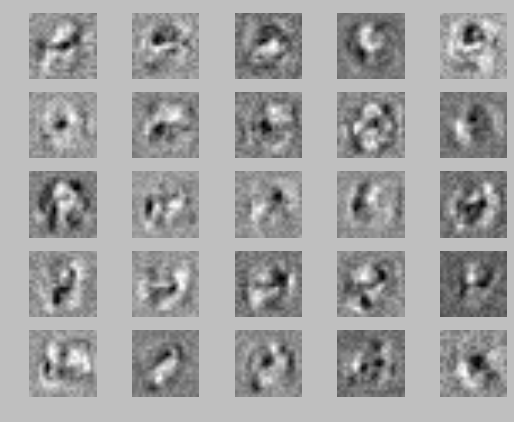

In [148]:
# visualizing hidden units
plot_indices = itertools.product(range(5), range(5))
images_indices = np.arange(25)

(f, ax) = plt.subplots(5, 5)
for (i, (j, k)) in zip(images_indices, plot_indices):
    image = thetas[0][i, 1:].reshape(20, 20)
    ax[j, k].imshow(image, cmap='gray')
    ax[j, k].axis('off')
    
plt.show()